
# Approximating the Runge Function and Its Derivative Using Neural Networks  

## 1. Introduction  
The Runge function  
$$
f(x) = \frac{1}{1+25x^2}, \quad x \in [-1,1],
$$  
is a classic example in numerical analysis. Because it varies rapidly near the interval boundaries, polynomial interpolation on equispaced nodes often suffers from the *Runge phenomenon*, producing large oscillatory errors.  

This experiment aims to approximate both the Runge function and its derivative using a neural network, and to evaluate how well the model learns both function values and slopes simultaneously.  

## 2. Methodology  
- **Data:** 200 training samples and 200 validation samples were drawn uniformly from $[-1,1]$. Both $f(x)$ and its analytical derivative $f'(x)$ were computed as supervision signals.  
- **Model architecture:** A two-hidden-layer multilayer perceptron (MLP) with 64 units per layer, \(\tanh\) activations, and Xavier initialization.  
- **Loss function:**  
  $$
  \mathcal{L} = \text{MSE}(f,\hat f) + \lambda \,\text{MSE}(f',\hat f'),
  $$  
  with $\lambda=0.2$. The reason for choosing $\lambda=0.2$ is that $f(x)$ lies within $[0,1]$, while $f'(x)$ can reach values around $\pm 3$. If both losses are weighted equally, the derivative term would dominate training and reduce function accuracy. By assigning a weight of 0.2, we balance the influence of function and derivative errors, ensuring that the network fits both effectively.  
- **Training setup:** Optimizer = Adam (learning rate $10^{-3}$, weight decay $10^{-6}$), batch size = 128. Maximum 3000 epochs with early stopping (patience = 300). 

## 3. Experiment  
1. Generate training and validation samples.  
2. Train the neural network by minimizing the total loss $\mathcal{L}$.  
3. Log training and validation errors every 200 epochs.  
4. After training, evaluate the best validation model on a dense 1000-point grid.  
5. Produce three plots:  
   - True function vs. predicted function.  
   - True derivative vs. predicted derivative.  
   - Training and validation loss curves.  

In [3]:
import math, os, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from dataclasses import dataclass
import matplotlib.pyplot as plt

torch.manual_seed(123)
np.random.seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def f_np(x):  # x: numpy array
    return 1.0 / (1.0 + 25.0 * x**2)

def fp_np(x):
    return -50.0 * x / (1.0 + 25.0 * x**2)**2

def f_torch(x):  # x: torch tensor
    return 1.0 / (1.0 + 25.0 * x**2)

def fp_torch(x):
    return -50.0 * x / (1.0 + 25.0 * x**2)**2

def sample_xy(n, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    x = rng.uniform(-1.0, 1.0, size=(n, 1)).astype(np.float32)
    y = f_np(x)
    yp = fp_np(x)
    return x, y, yp

n_train, n_val = 200, 200
rng = np.random.default_rng(42)
x_tr, y_tr, yp_tr = sample_xy(n_train, rng)
x_va, y_va, yp_va = sample_xy(n_val,   rng)

Xt = torch.from_numpy(x_tr).to(device)
Yt = torch.from_numpy(y_tr).to(device)
Ypt= torch.from_numpy(yp_tr).to(device)

Xv = torch.from_numpy(x_va).to(device)
Yv = torch.from_numpy(y_va).to(device)
Ypv= torch.from_numpy(yp_va).to(device)

# Dense grid for evaluation/plots
xg = np.linspace(-1, 1, 1000, dtype=np.float32).reshape(-1,1)
Xg = torch.from_numpy(xg).to(device)

# Model
class MLP(nn.Module):
    def __init__(self, h1=64, h2=64):
        super().__init__()
        self.l1 = nn.Linear(1, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, 1)
        # Xavier init
        for m in [self.l1, self.l2, self.l3]:
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    def forward(self, x):
        z = torch.tanh(self.l1(x))
        z = torch.tanh(self.l2(z))
        y = self.l3(z)
        return y

model = MLP(h1=64, h2=64).to(device)

# Loss & optimizer
@dataclass
class HParams:
    lr: float = 1e-3
    weight_decay: float = 1e-6
    batch_size: int = 128
    epochs: int = 3000
    lambda_deriv: float = 0.2   # weight for derivative loss
    patience: int = 300         # early stopping

hp = HParams()
opt = Adam(model.parameters(), lr=hp.lr, weight_decay=hp.weight_decay)

# Compute y and dy/dx
def pred_with_deriv(net, x):
    x = x.clone().detach().requires_grad_(True)
    y = net(x)
    # scalar w.r.t each sample: grad outputs ones
    grad = torch.autograd.grad(
        outputs=y, inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    return y, grad, x  # return x so caller can .detach_()

# Mini-batch iterator
def batch_indices(n, bs, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    idx = rng.permutation(n)
    for i in range(0, n, bs):
        yield idx[i:i+bs]

In [ ]:
# Training loop
train_mse_hist, train_dmse_hist = [], []
val_mse_hist,   val_dmse_hist   = [], []
best_state, best_val = None, float("inf")
no_improve = 0

for ep in range(1, hp.epochs+1):
    # training
    model.train()
    se, se_d, n_seen = 0.0, 0.0, 0
    for idx in batch_indices(len(Xt), hp.batch_size):
        xb, yb, ypb = Xt[idx], Yt[idx], Ypt[idx]
        yh, dy_dx, xb_autograd = pred_with_deriv(model, xb)
        loss_f  = F.mse_loss(yh, yb)
        loss_df = F.mse_loss(dy_dx, ypb)
        loss = loss_f + hp.lambda_deriv * loss_df

        opt.zero_grad()
        loss.backward()
        opt.step()

        with torch.no_grad():
            se   += F.mse_loss(yh,  yb,  reduction='sum').item()
            se_d += F.mse_loss(dy_dx, ypb, reduction='sum').item()
            n_seen += len(xb)

    train_mse  = se / n_seen
    train_dmse = se_d / n_seen
    train_mse_hist.append(train_mse)
    train_dmse_hist.append(train_dmse)

    # validation
    model.eval()
    xv = Xv.clone().requires_grad_(True)
    yv = model(xv)
    dv = torch.autograd.grad(
        outputs=yv, inputs=xv,
        grad_outputs=torch.ones_like(yv),
        create_graph=False, retain_graph=False, only_inputs=True
    )[0]

    val_mse  = F.mse_loss(yv, Yv).item()
    val_dmse = F.mse_loss(dv, Ypv).item()

    val_mse_hist.append(val_mse)
    val_dmse_hist.append(val_dmse)

    total_val = val_mse + hp.lambda_deriv * val_dmse
    if total_val + 1e-9 < best_val:
        best_val = total_val
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1

    if ep % 200 == 0 or ep == 1:
        print(f"[{ep:4d}] train MSE={train_mse:.4e}, dMSE={train_dmse:.4e} | "
              f"val MSE={val_mse:.4e}, dMSE={val_dmse:.4e}")

    if no_improve >= hp.patience:
        print(f"Early stopped at epoch {ep}.")
        break

# restore best
if best_state is not None:
    model.load_state_dict(best_state)

# Evaluation on dense grid
model.eval()
Xg_req = Xg.clone().requires_grad_(True)
Yg_hat = model(Xg_req)
dYg_dx = torch.autograd.grad(Yg_hat, Xg_req, torch.ones_like(Yg_hat), create_graph=False)[0]
Yg = f_torch(Xg); dYg = fp_torch(Xg)

with torch.no_grad():
    mse_f_grid  = F.mse_loss(Yg_hat, Yg).item()
    mse_df_grid = F.mse_loss(dYg_dx, dYg).item()
    maxerr_f    = torch.max(torch.abs(Yg_hat - Yg)).item()
    maxerr_df   = torch.max(torch.abs(dYg_dx - dYg)).item()

print({"MSE_f_grid": mse_f_grid, "MSE_df_grid": mse_df_grid,
       "MaxAbsErr_f": maxerr_f, "MaxAbsErr_df": maxerr_df})

# Plots
with torch.no_grad():
    xg_np = Xg.cpu().numpy().ravel()
    f_np_grid  = Yg.cpu().numpy().ravel()
    fp_np_grid = dYg.cpu().numpy().ravel()
    y_hat_np   = Yg_hat.cpu().numpy().ravel()
    dy_hat_np  = dYg_dx.cpu().numpy().ravel()

[   1] train MSE=2.1552e-01, dMSE=2.2164e+00 | val MSE=1.5100e-01, dMSE=2.0405e+00
[ 200] train MSE=4.9333e-05, dMSE=6.0096e-03 | val MSE=4.4695e-05, dMSE=7.2088e-03
[ 400] train MSE=5.5897e-06, dMSE=7.4564e-04 | val MSE=3.3236e-06, dMSE=7.3724e-04
[ 600] train MSE=5.8821e-06, dMSE=3.4757e-04 | val MSE=6.9916e-06, dMSE=4.1490e-04
[ 800] train MSE=1.0447e-06, dMSE=1.9944e-04 | val MSE=1.1641e-06, dMSE=2.3738e-04
[1000] train MSE=8.2026e-07, dMSE=1.2025e-04 | val MSE=5.9989e-06, dMSE=1.5421e-04
[1200] train MSE=2.8184e-07, dMSE=8.1146e-05 | val MSE=1.8320e-07, dMSE=8.9305e-05
[1400] train MSE=3.9725e-06, dMSE=6.6371e-05 | val MSE=3.0599e-06, dMSE=6.9442e-05
[1600] train MSE=3.3989e-06, dMSE=5.8646e-05 | val MSE=2.5334e-06, dMSE=5.6240e-05
[1800] train MSE=8.0348e-06, dMSE=7.4948e-05 | val MSE=5.3968e-06, dMSE=5.2943e-05
[2000] train MSE=1.1194e-05, dMSE=6.0929e-05 | val MSE=2.1346e-05, dMSE=9.2178e-05
[2200] train MSE=1.5260e-05, dMSE=6.3088e-05 | val MSE=2.6205e-06, dMSE=2.2910e-05
[240

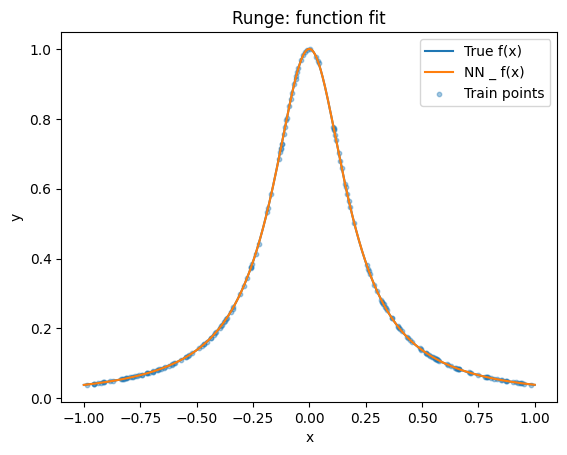

In [6]:
# 1) f vs \hat f
plt.figure()
plt.plot(xg_np, f_np_grid, label="True f(x)")
plt.plot(xg_np, y_hat_np, label="NN \u005f f(x)")
plt.scatter(x_tr.ravel(), y_tr.ravel(), s=10, alpha=0.4, label="Train points")
plt.title("Runge: function fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.show()

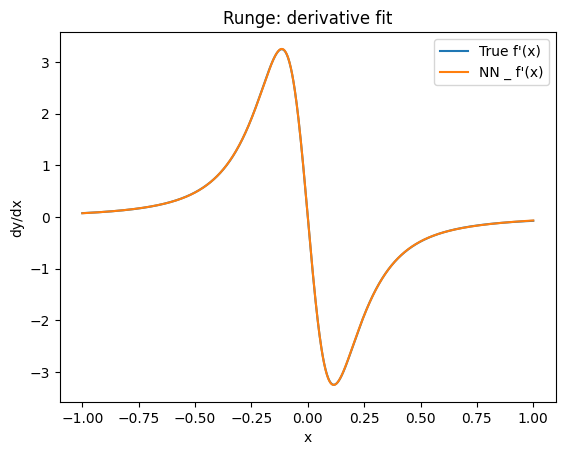

In [7]:
# 2) f' vs \hat f'
plt.figure()
plt.plot(xg_np, fp_np_grid, label="True f'(x)")
plt.plot(xg_np, dy_hat_np, label="NN \u005f f'(x)")
plt.title("Runge: derivative fit")
plt.xlabel("x"); plt.ylabel("dy/dx")
plt.legend(); plt.show()

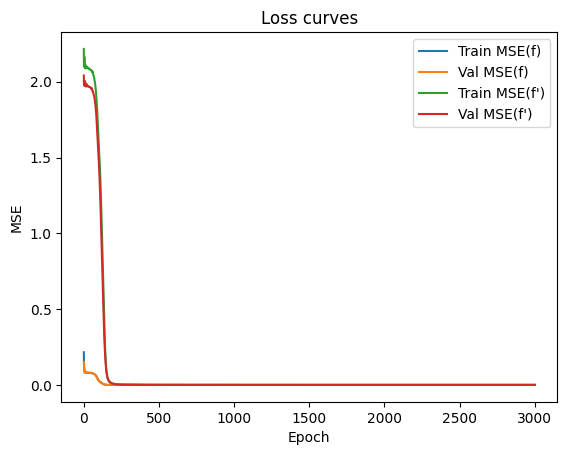

In [8]:
# 3) Loss curves
epochs_run = len(train_mse_hist)

plt.figure()
plt.plot(range(1, len(train_mse_hist)+1), train_mse_hist, label="Train MSE(f)")
plt.plot(range(1, len(val_mse_hist)+1),   val_mse_hist,   label="Val MSE(f)")
plt.plot(range(1, len(train_dmse_hist)+1), train_dmse_hist, label="Train MSE(f')")
plt.plot(range(1, len(val_dmse_hist)+1),   val_dmse_hist,   label="Val MSE(f')")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.title("Loss curves")
plt.legend(); plt.show()

## 4. Result  
- **Training log:** Both training and validation MSE dropped rapidly within the first 200–400 epochs. At convergence, losses stabilized near zero.  
- **Final grid evaluation (1000 points):**  
  - Function MSE ($f$): **6.25e-06**  
  - Derivative MSE ($f'$): **7.71e-06**  
  - Maximum absolute error ($f$): **5.65e-04**  
  - Maximum absolute error ($f'$): **8.57e-03**  

- **Plots:**  
  - Function approximation: Predicted $\hat f(x)$ nearly identical to the true function.  
  - Derivative approximation: Predicted $\hat f'(x)$ overlapped closely with the analytical derivative.  
  - Loss curves: Training and validation errors for both tasks decreased together and remained stable, showing no signs of overfitting.  

## 5. Discussion  
The Runge function changes most sharply near the origin, making it the hardest region to approximate. Nevertheless, the neural network successfully captured both the overall shape and local slope of the function.  

Including derivative loss acted as a **shape regularizer**, constraining the network to respect both function values and slopes. This reduced the chance of spurious oscillations. The choice of $\lambda=0.2$ was critical:  
- If too large, the model would overemphasize slope fitting, degrading function accuracy.  
- If too small, slope prediction would lag behind.  
The current setting yielded balanced, stable performance, as shown by the low MSE and maximum errors.  

## 6. Conclusion  
This study shows that even a relatively small neural network can accurately approximate both the Runge function and its derivative. With only 200 training samples, the model achieved grid-level MSEs on the order of $10^{-6}$ for both function and derivative.  

Key findings:  
1. Neural networks avoid the oscillations of polynomial interpolation for the Runge function.  
2. Adding derivative loss improves stability and ensures accurate slope learning.  
3. A carefully chosen derivative weight ($\lambda=0.2$) effectively balances accuracy between function and slope approximation.  
4. Final evaluation confirmed very small errors: maximum function error under $10^{-3}$, and derivative error under $10^{-2}$.  